<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

## The Studentized Bootstrap



In [2]:
times = (np.random.exponential(scale=300, size=13825) +
         np.abs(np.random.normal(loc=50, scale=40, size=13825)))

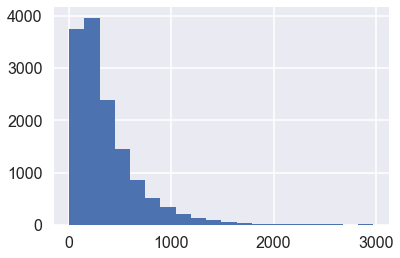

In [3]:
plt.hist(times, bins=20);

**Population parameter**

In [34]:
def stat(sample, axis=None): return np.mean(sample, axis=axis)

In [35]:
theta = stat(times)
theta

354.88514345436835

**Sampling distribution using samples from population**

In [36]:
n = 10
samples_from_pop = 1000

def take_sample(n=n): return np.random.choice(times, size=n, replace=False)

In [37]:
pop_sampling_dist = np.array(
    [stat(take_sample()) for _ in range(samples_from_pop)]
)

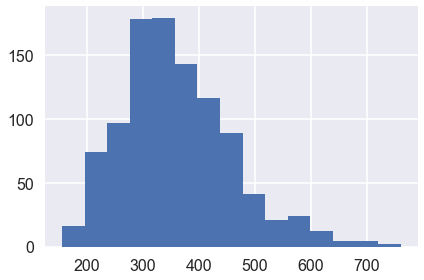

In [38]:
plt.hist(pop_sampling_dist, bins=15)
plt.tight_layout()

** Distribution of $ \hat{\theta} - \theta $**

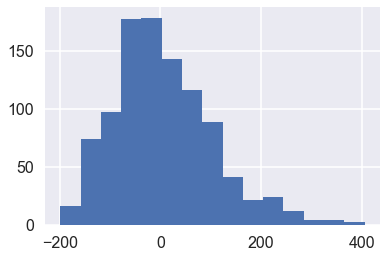

In [39]:
plt.hist(pop_sampling_dist - theta, bins=15);

**Bootstrap sampling distribution**

In [40]:
bootstrap_reps = 1000

In [41]:
def resample(sample, reps):
    n = len(sample)
    return np.random.choice(sample, size=reps * n).reshape((reps, n))

def bootstrap_stats(sample, reps=bootstrap_reps, stat=stat):
    resamples = resample(sample, reps)
    return stat(resamples, axis=1)

** Distribution of $ \tilde{\theta} - \hat{\theta}$**

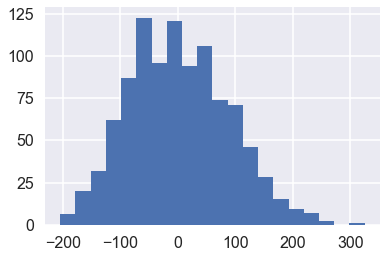

In [42]:
np.random.seed(0)

sample = take_sample()

plt.hist(bootstrap_stats(sample) - stat(sample), bins=20);

**Distribution of $ (\hat{\theta} - \theta) / SE(\hat \theta) $ vs. $ (\tilde{\theta} - \hat \theta) / SE(\tilde \theta) $ **

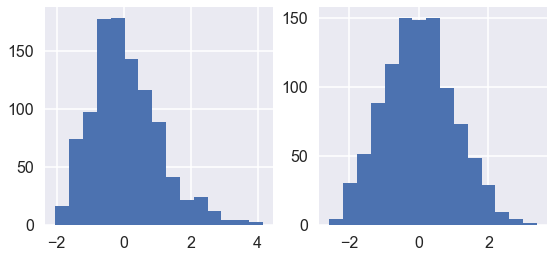

In [43]:
np.random.seed(0)
plt.figure(figsize=(9, 4))

plt.subplot(121)
plt.hist((pop_sampling_dist - theta) / np.std(pop_sampling_dist), bins=15);

tilde_thetas = bootstrap_stats(sample)
plt.subplot(122)
plt.hist((tilde_thetas - stat(sample)) / np.std(tilde_thetas), bins=15);

**Percentile bootstrap coverage**

In [44]:
confidence = 95
percentiles = [2.5, 97.5]

In [45]:
def percentile_ci(sample, reps=bootstrap_reps, stat=stat):
    stats = bootstrap_stats(sample, reps, stat)
    return np.percentile(stats, percentiles)

In [74]:
%%time

np.random.seed(0)
samples = [take_sample() for _ in range(samples_from_pop)]
percentile_cis = [percentile_ci(sample) for sample in t(samples)]

100%|██████████| 1000/1000 [00:00<00:00, 2051.78it/s]


CPU times: user 805 ms, sys: 32.8 ms, total: 838 ms
Wall time: 901 ms


In [75]:
def coverage(cis, parameter=theta):
    return (
        np.count_nonzero([lower < parameter < upper for lower, upper in cis])
        / len(cis)
    )

In [76]:
coverage(percentile_cis)

0.861

**Studentized bootstrap coverage**

In [77]:
inner_bootstrap_reps = 50

test = None
 
def studentized_ci(sample, reps=bootstrap_reps, stat=stat):
    resamples = resample(sample, reps)
    resample_stats = stat(resamples, axis=1)
    resample_sd = np.std(resample_stats)
    
    resample_std_errs = np.std(resamples, axis=1) / np.sqrt(len(sample))
    
    sample_stat = stat(sample)
    t_statistics = (resample_stats - sample_stat) / resample_std_errs
    
    lower, upper = np.percentile(t_statistics, percentiles)
    return (sample_stat - resample_sd * upper,
            sample_stat - resample_sd * lower)

In [78]:
%%time

np.random.seed(0)
samples = [take_sample() for _ in range(samples_from_pop)]
studentized_cis = [studentized_ci(sample) for sample in t(samples)]

100%|██████████| 1000/1000 [00:00<00:00, 1484.56it/s]

CPU times: user 999 ms, sys: 12.5 ms, total: 1.01 s
Wall time: 1.01 s


In [79]:
coverage(studentized_cis)

0.938

**Increasing the sample size**

In [80]:
def run_trials(sample_sizes):
    np.random.seed(0)
    percentile_coverages = []
    studentized_coverages = []
    
    for n in t(sample_sizes):
        samples = [take_sample(n) for _ in range(samples_from_pop)]
        percentile_cis = [percentile_ci(sample) for sample in samples]
        studentized_cis = [studentized_ci(sample) for sample in samples]
        
        percentile_coverages.append(coverage(percentile_cis))
        studentized_coverages.append(coverage(studentized_cis))
    return pd.DataFrame({
        'percentile': percentile_coverages,
        'studentized': studentized_coverages,
    }, index=sample_sizes)

In [81]:
%%time

trials = run_trials(np.arange(10, 201, 5))

100%|██████████| 39/39 [03:58<00:00,  6.12s/it]

CPU times: user 3min 33s, sys: 21.6 s, total: 3min 54s
Wall time: 3min 58s


In [82]:
trials

,percentile,studentized
10,0.861,0.938
15,0.898,0.936
20,0.888,0.932
...,...,...
190,0.925,0.933
195,0.951,0.955
200,0.950,0.947


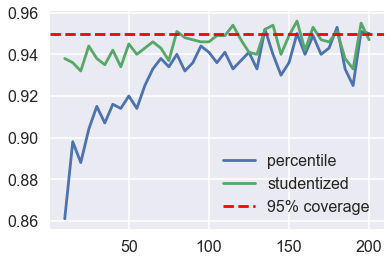

In [83]:
trials.plot()
plt.axhline(0.95, c='red', linestyle='--', label='95% coverage')
plt.legend();